# Final Project

In [1]:
!pip install lime
!pip install tensorflow -U
!pip install kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=898062f4a9e45660401fe6d163d321bbaf236af3b03fe0208ecff6e5e74c49f7
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: t

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import kagglehub

In [3]:
print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Dataset downloaded to:", dataset_path)


base_dir = os.path.join(dataset_path, 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')
img_width, img_height = 224, 224


Dataset downloaded to: /kaggle/input/chest-xray-pneumonia


In [4]:
def apply_clahe(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.convertScaleAbs(gray)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

def preprocessing_function(image):
    image = apply_clahe(image)
    return image / 255.0

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing_function,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [6]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [7]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2, min_lr=1e-7)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=30,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights
)


for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, lr_reduction],
    class_weight=class_weights
)

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.5164 - loss: 0.8544 - val_accuracy: 0.6875 - val_loss: 0.6470 - learning_rate: 1.0000e-04
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5588 - loss: 0.7536 - val_accuracy: 0.6875 - val_loss: 0.6281 - learning_rate: 1.0000e-04
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.5678 - loss: 0.7247 - val_accuracy: 0.6250 - val_loss: 0.6115 - learning_rate: 1.0000e-04
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6045 - loss: 0.6842 - val_accuracy: 0.7500 - val_loss: 0.6045 - learning_rate: 1.0000e-04
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6138 - loss: 0.6746 - val_accuracy: 0.6875 - val_loss: 0.6088 - learning_rate: 1.0000e-04
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.6295 - loss: 0.6478 - val_accuracy: 0.6875 - val_loss: 0.6033 - learning_rate: 1.0000e-04
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6657 

624/624 ━━━━━━━━━━━━━━━━━━━━ 22s 26ms/step - accuracy: 0.8833 - loss: 0.2803
Test Accuracy: 0.88
624/624 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step
              precision    recall  f1-score   support

      Normal       0.82      0.86      0.84       234
   Pneumonia       0.91      0.89      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.87      0.87       624
weighted avg       0.88      0.88      0.88       624



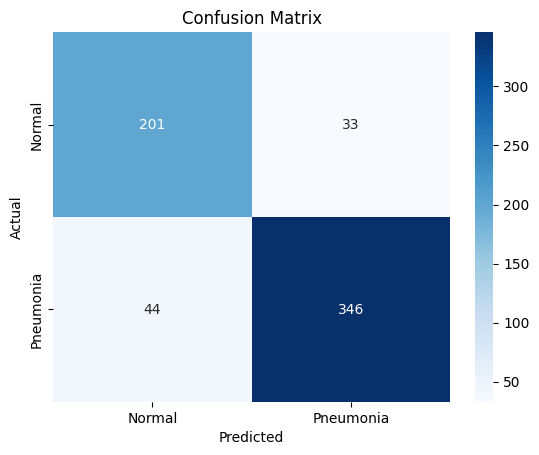

In [8]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples)
print(f'Test Accuracy: {test_acc:.2f}')

Y_pred = model.predict(test_generator, steps=test_generator.samples)
y_pred = np.round(Y_pred).astype(int).reshape(-1)
y_true = test_generator.classes[:len(y_pred)]

print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


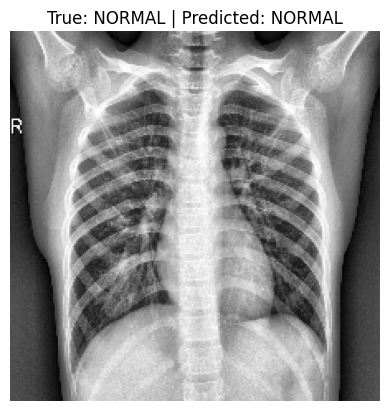

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


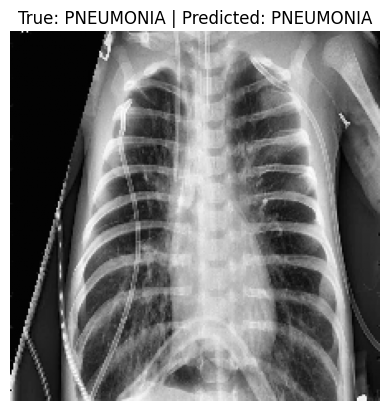

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


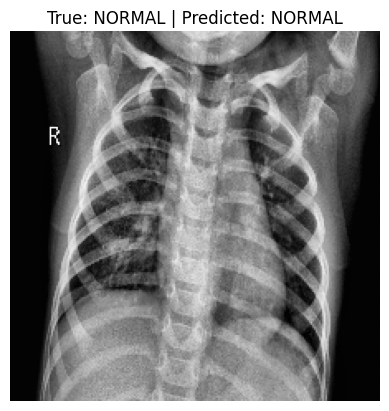

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


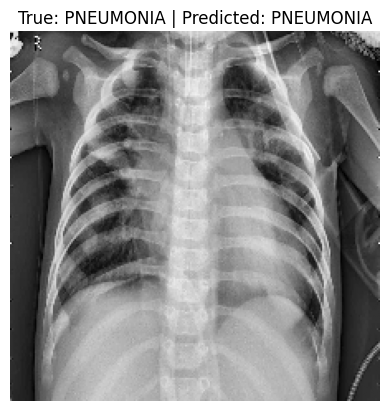

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


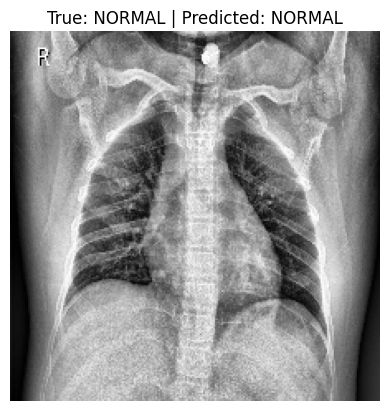

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


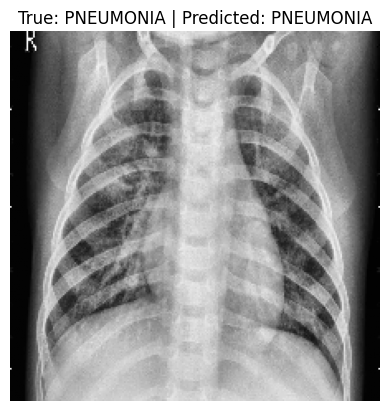

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


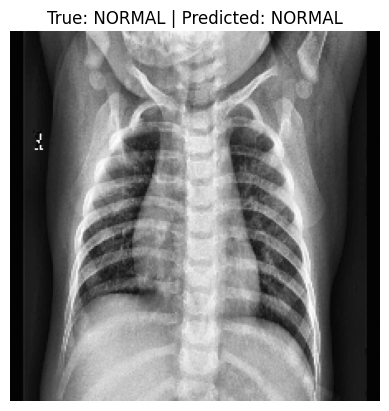

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


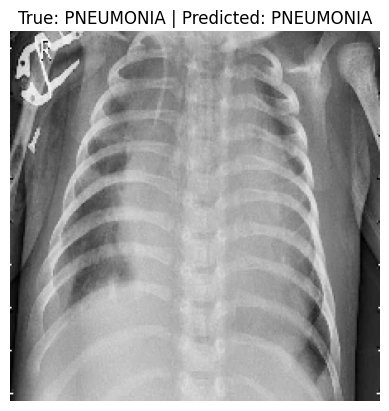

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


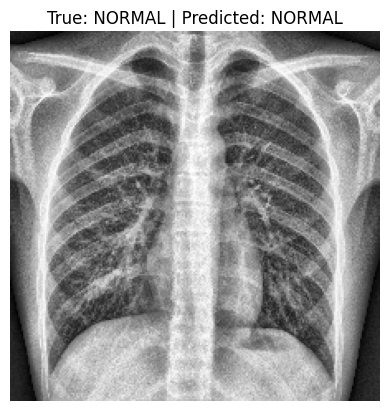

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


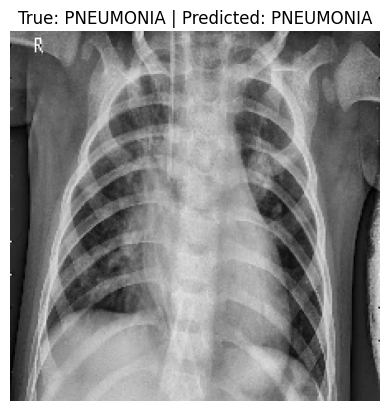

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


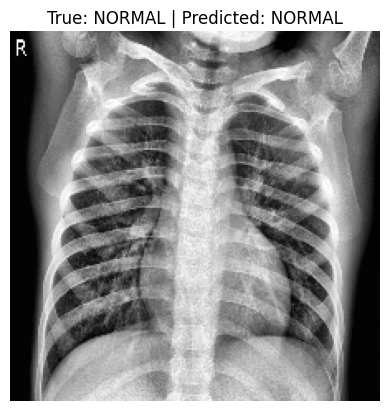

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


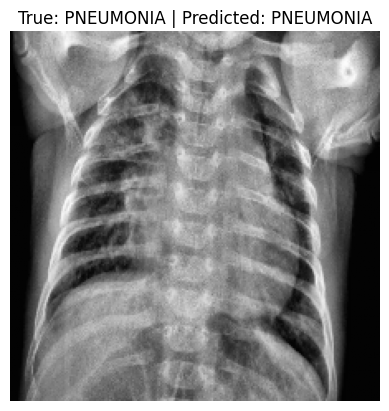

In [9]:
filenames = test_generator.filenames
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

def get_mixed_indices(y_true, max_samples=9):
    normal = [i for i, label in enumerate(y_true) if label == 0]
    pneumonia = [i for i, label in enumerate(y_true) if label == 1]
    np.random.shuffle(normal)
    np.random.shuffle(pneumonia)
    mixed = []
    for i in range(max_samples):
        mixed.append(normal[i % len(normal)])
        mixed.append(pneumonia[i % len(pneumonia)])
        if len(mixed) >= max_samples:
            break
    return mixed[:max_samples]

mixed_indices = get_mixed_indices(y_true, max_samples=12)

for i in mixed_indices:
    img_path = os.path.join(test_dir, filenames[i])
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = apply_clahe(img_array.astype(np.uint8))
    img_array = img_array / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array_expanded)
    predicted_label = class_labels[int(prediction[0][0] > 0.5)]
    true_label = class_labels[y_true[i]]

    plt.imshow(img_array)
    plt.title(f'True: {true_label} | Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()


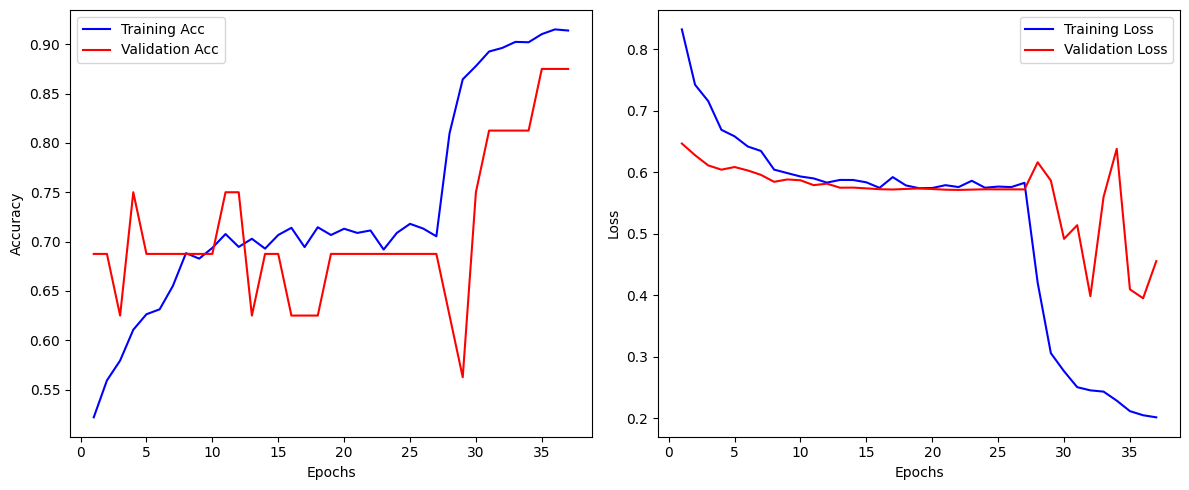

In [10]:
def plot_training_history(histories):
    acc, val_acc, loss, val_loss = [], [], [], []
    for h in histories:
        acc.extend(h.history['accuracy'])
        val_acc.extend(h.history['val_accuracy'])
        loss.extend(h.history['loss'])
        val_loss.extend(h.history['val_loss'])

    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training Acc')
    plt.plot(epochs, val_acc, 'r', label='Validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history([history, fine_tune_history])

Explaining prediction using LIME...


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102

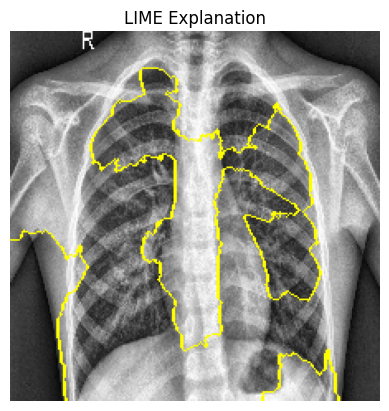

In [11]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

print("Explaining prediction using LIME...")

explainer = lime_image.LimeImageExplainer()
index = 0
img_path = os.path.join(test_dir, filenames[index])
img = image.load_img(img_path, target_size=(img_width, img_height))
img_array = image.img_to_array(img).astype(np.uint8)
img_array_clahe = apply_clahe(img_array)
img_normalized = img_array_clahe / 255.0

def predict_fn(images):
    images = np.array([apply_clahe((img * 255).astype(np.uint8)) / 255.0 for img in images])
    return np.concatenate([(1 - model.predict(images)), model.predict(images)], axis=1)

explanation = explainer.explain_instance(
    img_normalized,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=10,
    min_weight=0.0
)

plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()